In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from cycler import cycler
import numpy as np
import polyan

#define a reference profile based on a representative polysome experimental profile
ref_peaks = [0.003, 0.0051, 0.026, 0.018, 0.0205, 0.0155, 0.012, 0.0085, 0.008, 0.006, 0.005, 0.0035, 0.002, 0.0015, 0.001, 0.0005, 0.0002, 5e-05]
ref_peaks = ref_peaks/ np.sum(ref_peaks)
x_ref,y_ref = polyan.plot_poly(ref_peaks)

<a name='TOC'></a>
<h1>In this Notebook</h1>
<ul style="font-size:20px">
    <li><a href="#ribosome_densities_high">Origin of excess heavy polysome signals</a></li>
    <li><a href="#ribosome_densities_low">Origin of depleted heavy polysome signals</a></li>
</ul>

<a name="ribosome_densities_high"></a>
<h2>Origin of excess heavy polysome signals</h2>
<p>This analysis traces the origin of highly ribosome-dense transcripts in a dataset showing aberrant high-polysome peaks. The reference and control dataset can be changed by setting the 'dataset' and 'con_dataset' variables in the next cell to other GEO identifiers for the yeast datasets in our list.</p>
<p><a href='#TOC'>Back to top.</a></p>

In [2]:
#prepare the standard polyan plot of the dataset
dataset = 'GSE108778'
data_peaks = polyan.fp2poly(pd.read_csv('Data/'+dataset+'.csv')[['ORF','Ribo_Prints']],has_RNA=False)
x,y = polyan.plot_poly(data_peaks)

#prepare the standard polyan plot of the control dataset
con_dataset = 'GSE87614'
control_peaks = polyan.fp2poly(pd.read_csv('Data/'+con_dataset+'.csv')[['ORF','Ribo_Prints']],has_RNA=False)
con_x,con_y = polyan.plot_poly(control_peaks)

#reproduce the calculations used in generating the profile
#for the analysis dataset

genes = pd.read_csv('Data/SacCer3.csv')[['systematic','RNA_Prints','length']]
genes.columns = ['ORF','RNA_Prints','length']

#read in the dataset and combine with gene length data
data = pd.read_csv('Data/'+dataset+'.csv')[['ORF','Ribo_Prints']]
data = data.merge(genes, on='ORF',how='inner')
data = data.dropna(subset=['Ribo_Prints','RNA_Prints'])

#calculate the ribosomes per mRNA (these calculations reproduce the polyan calculations exactly for the 'Scer' parameters)
data['RNA_RPK'] = data['RNA_Prints']/(data['length']/1000)
RiboPrints2Ribos = (200000 * 0.85) / sum(data['Ribo_Prints'])
data['Ribos_bound'] = data['Ribo_Prints'] * RiboPrints2Ribos
RNARPK2RNAs = 60000 / sum(data['RNA_RPK'])
data['RNAs_per_cell'] = data['RNA_RPK'] * RNARPK2RNAs
data['RperR'] = data['Ribos_bound'] / data['RNAs_per_cell']
data = data.dropna()
data = data.loc[data['RperR'] <= 30]
data = data.loc[data['RNAs_per_cell'] > 0.05]

#add color values to highlight genes between 8 and 10 ribosomes per RNA in orange
data['color'] = 'black'
for row in range(data.shape[0]):
    if data.iloc[row]['RperR'] > 17:
        data.iloc[row,8] = 'darkorange'

#reproduce the calculations used in generating the profile
#for the control dataset

#read in the control dataset and combine with gene length data and color indicators of the first dataset
con_data = pd.read_csv('Data/'+con_dataset+'.csv')[['ORF','Ribo_Prints']]
con_data = con_data.merge(genes, on='ORF',how='inner')
con_data = con_data.dropna(subset=['Ribo_Prints','RNA_Prints'])
con_data = con_data.merge(data[['ORF','color']], how='inner',on='ORF')
#calculate the ribosomes per mRNA (these calculations reproduce the polyan calculations exactly for the 'Scer' parameters)
con_data['RNA_RPK'] = con_data['RNA_Prints']/(con_data['length']/1000)
RiboPrints2Ribos = (200000 * 0.85) / sum(con_data['Ribo_Prints'])
con_data['Ribos_bound'] = con_data['Ribo_Prints'] * RiboPrints2Ribos
RNARPK2RNAs = 60000 / sum(con_data['RNA_RPK'])
con_data['RNAs_per_cell'] = con_data['RNA_RPK'] * RNARPK2RNAs
con_data['RperR'] = con_data['Ribos_bound'] / con_data['RNAs_per_cell']
con_data = con_data.dropna()
con_data = con_data.loc[con_data['RperR'] <= 30]
con_data = con_data.loc[con_data['RNAs_per_cell'] > 0.05]
#separate red and black datapoints to control plotting order
con_data_black = con_data.loc[con_data['color'] == 'black']
con_data_orange = con_data.loc[con_data['color'] == 'darkorange']

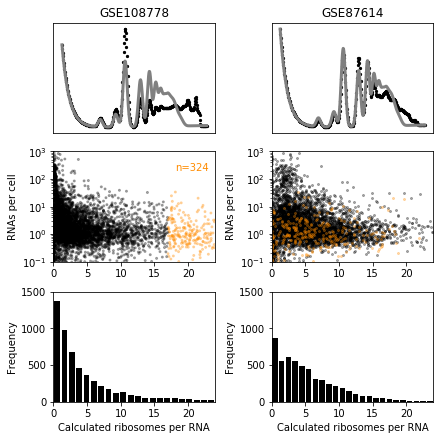

In [3]:
#plot results
fig,axs = plt.subplots(3,2,figsize = (6,6),constrained_layout = True)
axs[0,0].plot(x_ref,y_ref,c='grey',linewidth=3)
axs[0,0].scatter(x,y,c='black',s=5)
axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].set_title(dataset)
axs[0,1].plot(x_ref,y_ref,c='grey',linewidth=3)
axs[0,1].scatter(con_x,con_y,c='black',s=5)
axs[0,1].set_xticks([])
axs[0,1].set_yticks([])
axs[0,1].set_title(con_dataset)
axs[1,0].scatter(data['RperR'],data['RNAs_per_cell'],s=4,c=data['color'],alpha = 0.3)
axs[1,0].text(18,200,'n=' + str(con_data_orange.shape[0]),color='darkorange')
axs[1,0].set_ylabel('RNAs per cell')
axs[1,0].set_ylim((0.1,1000))
axs[1,0].set_yscale('log')
axs[1,0].set_xlim(0,24)
axs[1,1].scatter(con_data_black['RperR'],con_data_black['RNAs_per_cell'],s=4,c='black',alpha = 0.3)
axs[1,1].scatter(con_data_orange['RperR'],con_data_orange['RNAs_per_cell'],s=4,c='darkorange',alpha = 0.3)
axs[1,1].set_ylabel('RNAs per cell')
axs[1,1].set_ylim((0.1,1000))
axs[1,1].set_yscale('log')
axs[1,1].set_xlim(0,24)
axs[2,0].hist(data['RperR'],bins = 22,range=(0,24),rwidth = 0.8,color='black')
axs[2,0].set_xlim(0,24)
axs[2,0].set_ylim(0,1500)
axs[2,0].set_xlabel('Calculated ribosomes per RNA')
axs[2,0].set_ylabel('Frequency')
axs[2,1].hist(con_data['RperR'],bins = 24, range = (0,24), rwidth=0.8,color='black')
axs[2,1].set_xlim(0,24)
axs[2,1].set_ylim(0,1500)
axs[2,1].set_xlabel('Calculated ribosomes per RNA')
axs[2,1].set_ylabel('Frequency')
#plt.savefig('Extra_peak_tracing.svg')
plt.show()

<a name="ribosome_densities_low"></a>
<h2>Origin of depleted heavy polysome signals</h2>
<p>This analysis traces the origin of highly ribosome-dense transcripts in a dataset showing aberrant high-polysome peaks. The reference and control dataset can be changed by setting the 'dataset' and 'con_dataset' variables in the next cell to other GEO identifiers for the yeast datasets in our list.</p>
<p><a href='#TOC'>Back to top.</a></p>

In [4]:
#prepare the standard polyan plot of the dataset
dataset = 'GSE100626'
ref_peaks = [0.003, 0.0051, 0.026, 0.018, 0.0205, 0.0155, 0.012, 0.0085, 0.008, 0.006, 0.005, 0.0035, 0.002, 0.0015, 0.001, 0.0005, 0.0002, 5e-05]
ref_peaks = ref_peaks/ np.sum(ref_peaks)
x_ref,y_ref = polyan.plot_poly(ref_peaks)
andats = pd.read_csv('Data/'+dataset+'.csv', index_col=False)
andats = andats.dropna(subset=['Ribo_Prints','RNA_Prints'])
data_peaks_own = polyan.fp2poly(andats,has_RNA=True)
x_own,y_own = polyan.plot_poly(data_peaks_own)
data_peaks_ext = polyan.fp2poly(andats[['ORF','Ribo_Prints']],has_RNA=False)
x_ext,y_ext = polyan.plot_poly(data_peaks_ext)

#prepare the standard polyan plot of the control dataset
con_dataset = 'GSE87614'
control_peaks = polyan.fp2poly(pd.read_csv('Data/'+con_dataset+'.csv', index_col=False))
con_x,con_y = polyan.plot_poly(control_peaks)

In [5]:
#reproduce the calculations used in generating the profile
#for the analysis dataset

#read in the dataset and combine with gene length data
genes = pd.read_csv('Data/SacCer3.csv')[['systematic','RNA_Prints','length']]
genes.columns = ['ORF','RNA_Prints','length']
andats_own = andats.merge(genes[['ORF','length']], how = 'inner', on = 'ORF')
andats_own = andats_own[['ORF','Ribo_Prints','RNA_Prints','length']]
andats_ext = andats[['ORF','Ribo_Prints']].merge(genes[['ORF','RNA_Prints','length']], how = 'inner', on = 'ORF')
andats_ext = andats_ext[['ORF','Ribo_Prints','RNA_Prints','length']]

#calculate the ribosomes per mRNA (these calculations reproduce the polyan calculations exactly for the 'Scer' parameters)
#for own RNA data
andats_own['RNA_RPK'] = andats_own['RNA_Prints']/(andats_own['length']/1000)
RiboPrints2Ribos = (200000 * 0.85) / sum(andats_own['Ribo_Prints'])
andats_own['Ribos_bound'] = andats_own['Ribo_Prints'] * RiboPrints2Ribos
RNARPK2RNAs = 60000 / sum(andats_own['RNA_RPK'])
andats_own['RNAs_per_cell'] = andats_own['RNA_RPK'] * RNARPK2RNAs
andats_own['RperR'] = andats_own['Ribos_bound'] / andats_own['RNAs_per_cell']
andats_own = andats_own.dropna()
andats_own = andats_own.loc[andats_own['RperR'] <= 30]
andats_own = andats_own.loc[andats_own['RNAs_per_cell'] > 0.05]

#for reference RNA data
andats_ext['RNA_RPK'] = andats_ext['RNA_Prints']/(andats_ext['length']/1000)
RiboPrints2Ribos = (200000 * 0.85) / sum(andats_ext['Ribo_Prints'])
andats_ext['Ribos_bound'] = andats_ext['Ribo_Prints'] * RiboPrints2Ribos
RNARPK2RNAs = 60000 / sum(andats_ext['RNA_RPK'])
andats_ext['RNAs_per_cell'] = andats_ext['RNA_RPK'] * RNARPK2RNAs
andats_ext['RperR'] = andats_ext['Ribos_bound'] / andats_ext['RNAs_per_cell']
andats_ext = andats_ext.dropna()
andats_ext = andats_ext.loc[andats_ext['RperR'] <= 30]
andats_ext = andats_ext.loc[andats_ext['RNAs_per_cell'] > 0.05]

#add color values to highlight genes between 8 and 10 ribosomes per RNA in red
andats_own['color'] = 'black'
for row in range(andats_own.shape[0]):
    if andats_own.iloc[row]['RperR'] > 10:
        andats_own.at[andats_own.index[row],'color'] = 'steelblue'

#add color information to andats_own
andats_ext = andats_ext.merge(andats_own[['ORF','color']], on = 'ORF',how ='inner')
#separate red and black datapoints to control plotting order
andats_ext_black = andats_ext.loc[andats_ext['color'] == 'black']
andats_ext_blue = andats_ext.loc[andats_ext['color'] == 'steelblue']


#reproduce the calculations used in generating the profile
#for the control dataset

#read in the control dataset and combine with gene length data and color indicators of the first dataset
con_data = pd.read_csv('Data/'+con_dataset+'.csv')[['ORF','Ribo_Prints']]
con_data = con_data.merge(genes, on='ORF',how='inner')
con_data = con_data.dropna(subset=['Ribo_Prints','RNA_Prints'])
con_data = con_data.merge(andats_own[['ORF','color']], how='inner',on='ORF')
#calculate the ribosomes per mRNA (these calculations reproduce the polyan calculations exactly for the 'Scer' parameters)
con_data['RNA_RPK'] = con_data['RNA_Prints']/(con_data['length']/1000)
RiboPrints2Ribos = (200000 * 0.85) / sum(con_data['Ribo_Prints'])
con_data['Ribos_bound'] = con_data['Ribo_Prints'] * RiboPrints2Ribos
RNARPK2RNAs = 60000 / sum(con_data['RNA_RPK'])
con_data['RNAs_per_cell'] = con_data['RNA_RPK'] * RNARPK2RNAs
con_data['RperR'] = con_data['Ribos_bound'] / con_data['RNAs_per_cell']
con_data = con_data.dropna()
con_data = con_data.loc[con_data['RperR'] <= 30]
con_data = con_data.loc[con_data['RNAs_per_cell'] > 0.05]
#separate red and black datapoints to control plotting order
con_data_black = con_data.loc[con_data['color'] == 'black']
con_data_blue = con_data.loc[con_data['color'] == 'steelblue']

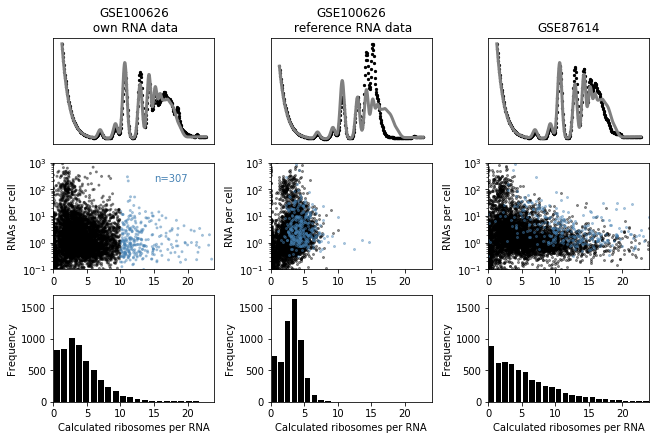

In [6]:
#plot results
fig,axs = plt.subplots(3,3,figsize = (9,6),constrained_layout = True)
axs[0,0].plot(x_ref,y_ref,c='grey',linewidth=3)
axs[0,0].scatter(x_own,y_own,c='black',s=5)
axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].set_title(dataset + '\n own RNA data')
axs[0,1].plot(x_ref,y_ref,c='grey',linewidth=3)
axs[0,1].scatter(x_ext,y_ext,c='black',s=5)
axs[0,1].set_xticks([])
axs[0,1].set_yticks([])
axs[0,1].set_title(dataset + '\n reference RNA data')
axs[0,2].plot(x_ref,y_ref,c='grey',linewidth=3)
axs[0,2].scatter(con_x,con_y,c='black',s=5)
axs[0,2].set_xticks([])
axs[0,2].set_yticks([])
axs[0,2].set_title('\n' + con_dataset)
axs[1,0].scatter(andats_own['RperR'],andats_own['RNAs_per_cell'],s=4,c=andats_own['color'],alpha = 0.4)
axs[1,0].text(15,200,'n=' + str(con_data_blue.shape[0]),color='steelblue')
axs[1,0].set_ylabel('RNAs per cell')
axs[1,0].set_ylim((0.1,1000))
axs[1,0].set_yscale('log')
axs[1,0].set_xlim(0,24)
axs[1,1].scatter(andats_ext_black['RperR'],andats_ext_black['RNAs_per_cell'],s=4,c='black',alpha = 0.4)
axs[1,1].scatter(andats_ext_blue['RperR'],andats_ext_blue['RNAs_per_cell'],s=4,c='steelblue',alpha = 0.4)
axs[1,1].set_ylabel('RNA per cell')
axs[1,1].set_ylim((0.1,1000))
axs[1,1].set_yscale('log')
axs[1,1].set_xlim(0,24)
axs[1,2].scatter(con_data_black['RperR'],con_data_black['RNAs_per_cell'],s=4,c='black',alpha = 0.4)
axs[1,2].scatter(con_data_blue['RperR'],con_data_blue['RNAs_per_cell'],s=4,c='steelblue',alpha = 0.4)
axs[1,2].set_ylabel('RNAs per cell')
axs[1,2].set_ylim((0.1,1000))
axs[1,2].set_yscale('log')
axs[1,2].set_xlim(0,24)
axs[2,0].hist(andats_own['RperR'],bins = 22,range=(0,24),rwidth = 0.8,color='black')
axs[2,0].set_xlim(0,24)
axs[2,0].set_ylim(0,1700)
axs[2,0].set_xlabel('Calculated ribosomes per RNA')
axs[2,0].set_ylabel('Frequency')
axs[2,1].hist(andats_ext['RperR'],bins = 24, range = (0,24), rwidth=0.8,color='black')
axs[2,1].set_xlim(0,24)
axs[2,1].set_ylim(0,1700)
axs[2,1].set_xlabel('Calculated ribosomes per RNA')
axs[2,1].set_ylabel('Frequency')
axs[2,2].hist(con_data['RperR'],bins = 24, range = (0,24), rwidth=0.8,color='black')
axs[2,2].set_xlim(0,24)
axs[2,2].set_ylim(0,1700)
axs[2,2].set_xlabel('Calculated ribosomes per RNA')
axs[2,2].set_ylabel('Frequency')
#plt.savefig('Depleted_peak_tracing.svg')
plt.show()